<a id="section1"></a>

血液検査データを用いて肝臓の疾患リスクの有無を判定するモデルを作成する

In [236]:
import pandas as pd # データ分析ライブラリ
import numpy as np # 三角関数，対数関数，行列などの数学的な計算を行うライブラリ
import seaborn as sns # グラフ可視化ライブラリ
import matplotlib.pyplot as plt # グラフ可視化ライブラリ
from pathlib import Path # ファイルパス操作ライブラリ

In [237]:
DATASET_PATH = Path('/Users/akiyoshi-n/Documents/data_analysis/data_analysis/data')

In [238]:
# disease: 0: 無，1: 有
# ここで一回データを変数に入れると以後楽になる
df = pd.read_excel(f'{DATASET_PATH}/disease_risk_prediction_data.xlsx')
print(df.head(5))

   Age  Gender  T_Bil  D_Bil  ALP  ALT_GPT  AST_GOT   TP  Alb  AG_ratio  \
0   65  Female    1.0    0.2  187       16       18  6.8  3.3      0.92   
1   62    Male   11.2    5.6  699       64      100  7.5  3.2      0.73   
2   62    Male    7.6    4.2  490       60       68  7.0  3.3      0.87   
3   58    Male    1.3    0.5  182       14       20  6.8  3.4      0.98   
4   72    Male    4.2    2.1  195       27       59  7.3  2.4      0.48   

   disease  
0        1  
1        1  
2        1  
3        1  
4        1  


データの種類(4種類)<br>
量的データ<br>
間隔尺度：データの差分に意味がある(西暦，温度)<br>
比例尺度：データの比率に意味がある(金額，個数)<br>
質的データ<br>
名義尺度：性別，名前，id<br>
順序尺度：順位，優劣を表す番号


In [239]:
print(df.shape)
print(df.info())

(800, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       800 non-null    int64  
 1   Gender    800 non-null    object 
 2   T_Bil     800 non-null    float64
 3   D_Bil     800 non-null    float64
 4   ALP       800 non-null    int64  
 5   ALT_GPT   800 non-null    int64  
 6   AST_GOT   800 non-null    int64  
 7   TP        800 non-null    float64
 8   Alb       800 non-null    float64
 9   AG_ratio  796 non-null    float64
 10  disease   800 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 68.9+ KB
None


In [240]:
df.isnull().sum()
# AG_ratioに欠損値がある

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    4
disease     0
dtype: int64

In [241]:
# .any(axis=1)で一行ごとにTrueがあるかどうかを判定
df.isnull().any(axis=1) # True, FalseのSeriesが返ってくる
df[df.isnull().any(axis=1)] # Trueの行を抽出
# NaNはNot a Numberの略で，数値ではないことを示す．

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
207,37,Male,1.1,0.3,147,27,46,5.0,2.5,NaN,1
239,65,Male,1.1,0.3,258,48,40,7.0,3.9,NaN,0
251,38,Male,0.8,0.2,247,55,92,7.4,4.3,NaN,0
310,12,Male,0.8,0.2,302,47,67,6.7,3.5,NaN,0


In [242]:
# 欠損値への対応：削除か値の代入
# 削除はdropna()，値の代入はfillna()
# 今回は代入．AG_ratioが他の変数の値から計算できる
# AG_ratio = Alb / (TP - Alb)
df['AG_ratio'].fillna(df['Alb'] / (df['TP'] - df['Alb']), inplace=True) # inplace=Trueで元データを置き換え

In [243]:
# 欠損値がなくなったか確認
df.isnull().sum()

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64

In [244]:
df.loc[[207,239,251,310], :]

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
207,37,Male,1.1,0.3,147,27,46,5.0,2.5,1.000000,1
239,65,Male,1.1,0.3,258,48,40,7.0,3.9,1.258065,0
251,38,Male,0.8,0.2,247,55,92,7.4,4.3,1.387097,0
310,12,Male,0.8,0.2,302,47,67,6.7,3.5,1.093750,0


In [245]:
# 重複データの確認
df.duplicated() # 上の行から確認して重複がなければFalseが返ってくる
print(df.duplicated().sum())
df[df.duplicated()] # 重複している行を抽出

10


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
577,70,Female,0.7,0.2,237,18,28,5.8,2.5,0.76,0
594,50,Female,1.0,0.3,191,22,31,7.8,4.0,1.05,0
628,25,Male,0.6,0.1,183,91,53,5.5,2.3,0.72,0
631,50,Male,0.7,0.2,192,18,15,7.4,4.2,1.31,0
659,51,Male,1.0,0.2,176,22,21,6.9,4.2,1.58,0
684,69,Female,0.8,0.2,146,42,70,8.4,4.9,1.40,0
713,65,Male,0.7,0.2,265,30,28,5.2,1.8,0.53,0
722,40,Male,0.7,0.2,175,27,42,5.4,2.4,0.84,0
735,65,Male,0.7,0.2,199,19,22,6.3,3.6,1.33,0
794,41,Male,0.9,0.2,169,22,18,6.1,3.0,0.97,0


In [246]:
df.drop_duplicates(inplace=True) # 重複データを削除
print(df.shape)

(790, 11)


In [247]:
# データのインデックスを振り直す
df.reset_index(drop=True, inplace=True) # drop=Flaseだとindexが新たな列として追加される

In [248]:
df.tail(5)
# 789まで

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
785,34,Male,1.9,1.0,222,35,133,6.1,2.8,0.86,0
786,29,Female,0.7,0.2,159,26,24,6.6,3.6,1.20,0
787,21,Male,0.8,0.2,184,33,56,6.9,3.6,1.08,0
788,40,Male,0.8,0.2,191,28,20,6.1,3.1,1.04,0
789,61,Male,0.6,0.1,188,20,21,6.2,3.3,1.17,0


### EDA

探索的分析(EDA): データを俯瞰し，データの特徴や予測のための手掛かりとなる仮説を立てるための網羅的な分析(外れ値を見つけたり，関係がありそうな変数を探したり)

In [249]:
# 基本統計量の確認
df.describe() # Genderは数値ではないので表示されない

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
count,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000
mean,43.710127,2.836709,1.226709,269.035443,66.174684,89.001266,6.518987,3.213924,0.991480,0.513924
std,16.290480,5.475744,2.483529,217.648811,155.959794,249.549767,1.032388,0.760867,0.288487,0.500123
min,4.000000,0.500000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.270000,0.000000
25%,32.000000,0.800000,0.200000,171.250000,22.000000,23.000000,5.900000,2.700000,0.810000,0.000000
50%,45.000000,1.100000,0.300000,198.000000,31.000000,35.000000,6.600000,3.200000,0.980000,1.000000
75%,57.000000,2.100000,0.900000,282.000000,52.750000,67.000000,7.200000,3.800000,1.170000,1.000000
max,90.000000,75.300000,19.800000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.840000,1.000000


In [250]:
# Genderの値を確認
df.describe(include='all') # include='all'で数値以外のデータも表示

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
count,790.000000,790,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,43.710127,NaN,2.836709,1.226709,269.035443,66.174684,89.001266,6.518987,3.213924,0.991480,0.513924
std,16.290480,NaN,5.475744,2.483529,217.648811,155.959794,249.549767,1.032388,0.760867,0.288487,0.500123
min,4.000000,NaN,0.500000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.270000,0.000000
25%,32.000000,NaN,0.800000,0.200000,171.250000,22.000000,23.000000,5.900000,2.700000,0.810000,0.000000
50%,45.000000,NaN,1.100000,0.300000,198.000000,31.000000,35.000000,6.600000,3.200000,0.980000,1.000000
75%,57.000000,NaN,2.100000,0.900000,282.000000,52.750000,67.000000,7.200000,3.800000,1.170000,1.000000


In [251]:
# 数量変数とカテゴリ変数の分離
col_categoric = ['Gender', 'disease']
df_numeric = df.drop(col_categoric, axis=1) # 数値変数のみのデータフレーム, axis=1で列方向に削除
print(df_numeric.head(5))
df_categoric = df[col_categoric] # カテゴリ変数のみのデータフレーム
print(df_categoric.head(5))

   Age  T_Bil  D_Bil  ALP  ALT_GPT  AST_GOT   TP  Alb  AG_ratio
0   65    1.0    0.2  187       16       18  6.8  3.3      0.92
1   62   11.2    5.6  699       64      100  7.5  3.2      0.73
2   62    7.6    4.2  490       60       68  7.0  3.3      0.87
3   58    1.3    0.5  182       14       20  6.8  3.4      0.98
4   72    4.2    2.1  195       27       59  7.3  2.4      0.48
   Gender  disease
0  Female        1
1    Male        1
2    Male        1
3    Male        1
4    Male        1


Gender
Male      600
Female    190
Name: count, dtype: int64


<Axes: xlabel='Gender'>

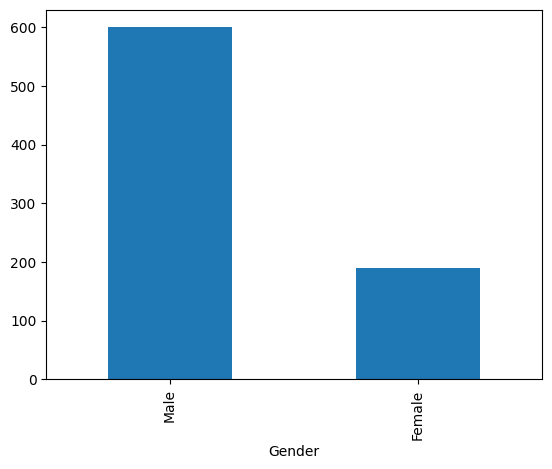

In [252]:
# 数量変数のデータの分布を確認
print(df_categoric['Gender'].value_counts())
counts_gender = df_categoric['Gender'].value_counts()
counts_gender.plot(kind='bar') # 棒グラフで表示

<Axes: xlabel='disease'>

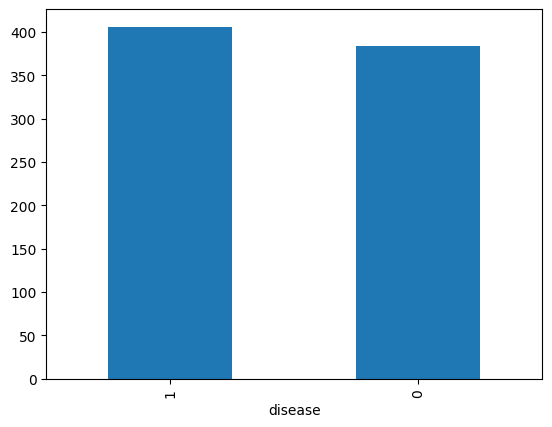

In [253]:
counts_disease = df_categoric['disease'].value_counts()
counts_disease.plot(kind='bar')

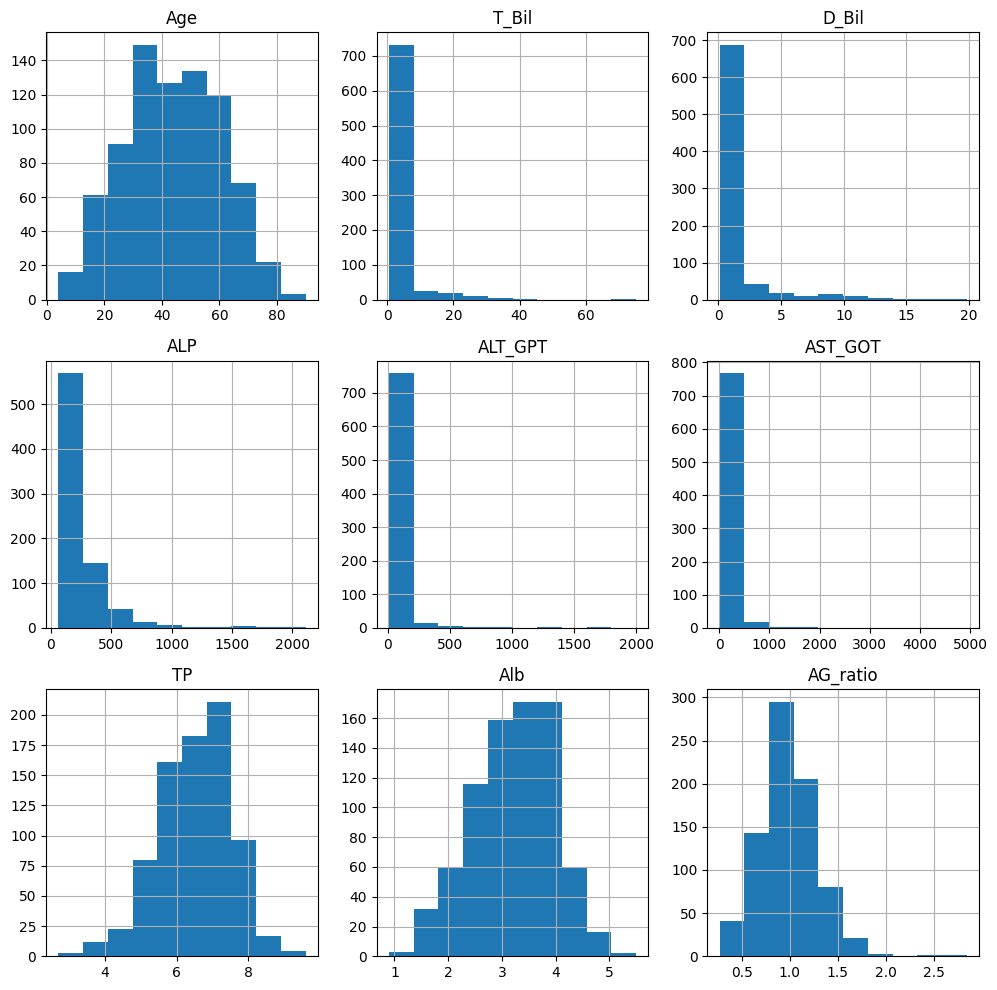

In [254]:
# 数量変数のデータの分布を確認
# histは数値データのみしか利用できない
df_numeric.hist(figsize=(10,10)) # figsizeでグラフの大きさを指定
plt.tight_layout() # グラフの重なりを解消

In [255]:
# 目的変数のカテゴリごとのデータの分布を確認
# df_numericにdisease列を結合
df_tmp = pd.concat([df_numeric, df_categoric['disease']], axis=1)
df_tmp.head(5)

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,65,1.0,0.2,187,16,18,6.8,3.3,0.92,1
1,62,11.2,5.6,699,64,100,7.5,3.2,0.73,1
2,62,7.6,4.2,490,60,68,7.0,3.3,0.87,1
3,58,1.3,0.5,182,14,20,6.8,3.4,0.98,1
4,72,4.2,2.1,195,27,59,7.3,2.4,0.48,1


In [256]:
# query関数を使用してdiseaseが0のデータと1のデータに分ける
df_tmp.query('disease == 0').head(5)

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
8,17,0.9,0.3,202,22,19,7.4,4.1,1.24,0
12,64,0.9,0.3,310,61,58,7.0,3.4,0.94,0
15,25,0.6,0.1,183,91,53,5.5,2.3,0.72,0
17,33,1.6,0.5,165,15,23,7.3,3.5,0.92,0
23,63,0.9,0.2,194,52,45,6.0,3.9,1.86,0


In [257]:
df_tmp.query('disease == 1').head(5)

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,65,1.0,0.2,187,16,18,6.8,3.3,0.92,1
1,62,11.2,5.6,699,64,100,7.5,3.2,0.73,1
2,62,7.6,4.2,490,60,68,7.0,3.3,0.87,1
3,58,1.3,0.5,182,14,20,6.8,3.4,0.98,1
4,72,4.2,2.1,195,27,59,7.3,2.4,0.48,1


In [258]:
# 疾患なしのデータからAgeの分布を確認
df_Age_non = df_tmp.query('disease == 0')['Age']
# 疾患ありのAgeの分布を確認
df_Age_diseased = df_tmp.query('disease == 1')['Age']

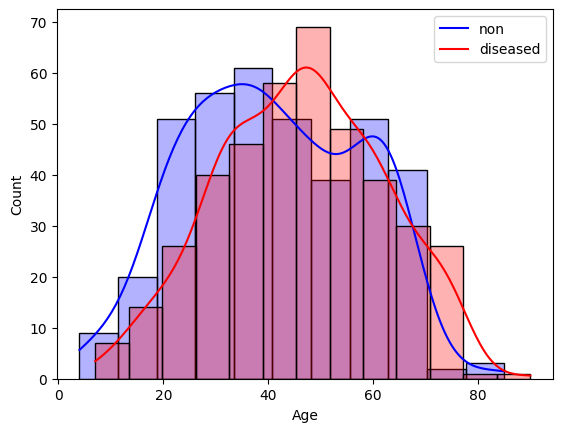

In [259]:
# ヒストグラムを重ねて書くにはseabornを使用．
# matplotlibでも書けるが，より簡単で美しい
import seaborn as sns
# ヒストグラムを重ねて描画
sns.histplot(df_Age_non, color='blue', label='non', alpha=0.3, kde=True) # kde=Trueでカーネル密度推定, alphaで透明度を指定
sns.histplot(df_Age_diseased, color='red', label='diseased', alpha=0.3, kde=True)
plt.legend(labels=['non', 'diseased'], loc='upper right') # 凡例の表示

(0.0, 2.0)

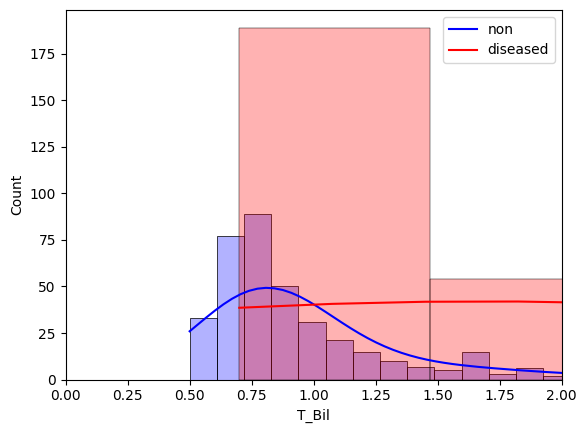

In [260]:
# T_Bilの分布を確認
df_T_Bil_non = df_tmp.query('disease == 0')['T_Bil']
df_T_Bil_diseased = df_tmp.query('disease == 1')['T_Bil']
sns.histplot(df_T_Bil_non, color='blue', label='non', alpha=0.3, kde=True)
sns.histplot(df_T_Bil_diseased, color='red', label='diseased', alpha=0.3, kde=True)
plt.legend(labels=['non', 'diseased'], loc='upper right')
plt.xlim(0, 2) # x軸の範囲を指定

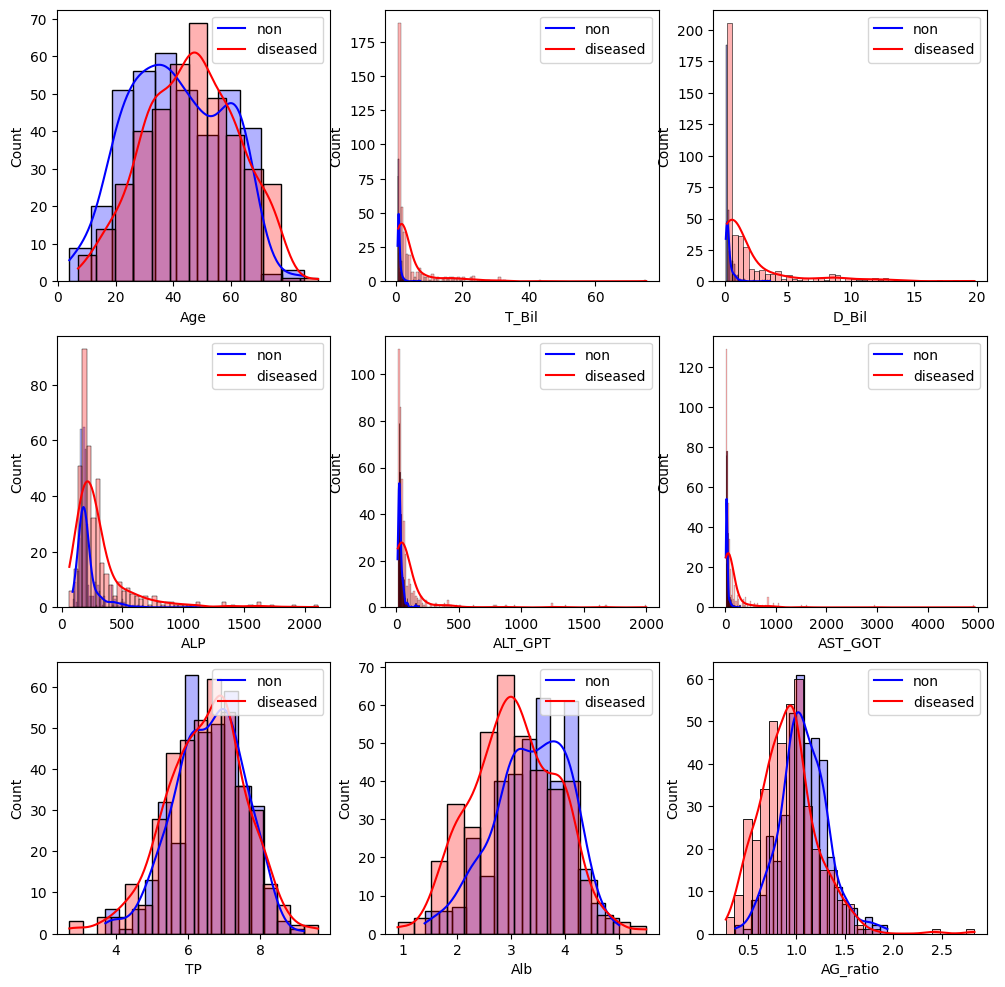

In [261]:
# df_numericには9つの変数あり
# subplotを使用して各変数と目的変数の関係を確認
#グラフの表示
plt.figure(figsize=(12, 12)) # figsizeでグラフの大きさを指定
for ncol, colname in enumerate(df_numeric.columns):
    plt.subplot(3, 3, ncol+1) # 3行3列のグラフのn+1番目に描画
    sns.histplot(df_tmp.query('disease == 0')[colname], color='blue', label='non', alpha=0.3, kde=True)
    sns.histplot(df_tmp.query('disease == 1')[colname], color='red', label='diseased', alpha=0.3, kde=True)
    plt.legend(labels=['non', 'diseased'], loc='upper right')
# Alb, AG_ratioは疾患ありの方が左に偏っている

In [262]:
# 相関係数の確認, 絶対値が1に近いほど相関が強い
# AgeとT_Bilの相関係数を確認
df[['Age', 'T_Bil']].corr()

,Age,T_Bil
Age,1.000000,0.033965
T_Bil,0.033965,1.000000


In [263]:
df_tmp.corr() # 全ての変数の相関係数を確認. 数値データのみのデータがdf_tmp

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
Age,1.000000,0.033965,0.030999,0.060460,-0.059396,-0.003819,-0.228393,-0.281486,-0.177030,0.161895
T_Bil,0.033965,1.000000,0.881271,0.236756,0.241730,0.260367,-0.016766,-0.227373,-0.281890,0.315357
D_Bil,0.030999,0.881271,1.000000,0.264557,0.261488,0.280029,-0.010099,-0.233630,-0.292797,0.340468
ALP,0.060460,0.236756,0.264557,1.000000,0.147286,0.183362,-0.025860,-0.177643,-0.247580,0.245491
ALT_GPT,-0.059396,0.241730,0.261488,0.147286,1.000000,0.795303,-0.034923,-0.041113,-0.023351,0.212509
AST_GOT,-0.003819,0.260367,0.280029,0.183362,0.795303,1.000000,-0.024031,-0.092083,-0.093665,0.199098
TP,-0.228393,-0.016766,-0.010099,-0.025860,-0.034923,-0.024031,1.000000,0.793025,0.207798,-0.048625
Alb,-0.281486,-0.227373,-0.233630,-0.177643,-0.041113,-0.092083,0.793025,1.000000,0.732303,-0.202018
AG_ratio,-0.177030,-0.281890,-0.292797,-0.247580,-0.023351,-0.093665,0.207798,0.732303,1.000000,-0.277248
disease,0.161895,0.315357,0.340468,0.245491,0.212509,0.199098,-0.048625,-0.202018,-0.277248,1.000000


<Axes: >

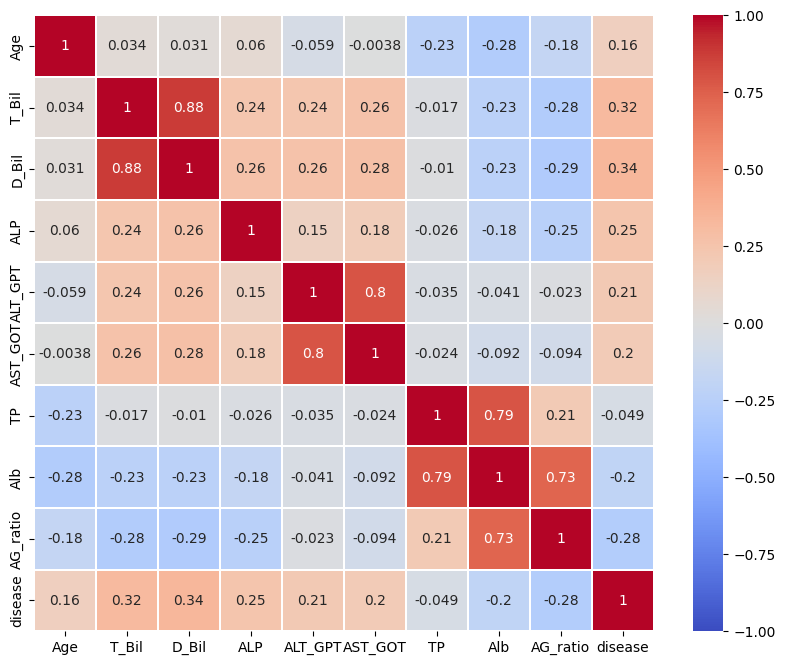

In [264]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_tmp.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1) # annot=Trueで数値を表示，cmapで色を指定，linewidthsでグラフの間隔を指定，vmin, vmaxで最小値，最大値を指定

In [265]:
# カテゴリ変数を数値に変換
# ラベルエンコーディングする方が早いきがするが，今回は無名関数を使用
df['Gender'] = df['Gender'].apply(lambda x : 1 if x=='Male' else 0) # Maleを1，Femaleを0に変換
# apply関数はSeriesの各要素に関数を適用する関数
df.head(5)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,65,0,1.0,0.2,187,16,18,6.8,3.3,0.92,1
1,62,1,11.2,5.6,699,64,100,7.5,3.2,0.73,1
2,62,1,7.6,4.2,490,60,68,7.0,3.3,0.87,1
3,58,1,1.3,0.5,182,14,20,6.8,3.4,0.98,1
4,72,1,4.2,2.1,195,27,59,7.3,2.4,0.48,1


In [266]:
# 説明変数と目的変数に分ける
X = df.drop('disease', axis=1) # 説明変数
y = df['disease'] # 目的変数
print(X)
print(y)

     Age  Gender  T_Bil  D_Bil  ALP  ALT_GPT  AST_GOT   TP  Alb  AG_ratio
0     65       0    1.0    0.2  187       16       18  6.8  3.3      0.92
1     62       1   11.2    5.6  699       64      100  7.5  3.2      0.73
2     62       1    7.6    4.2  490       60       68  7.0  3.3      0.87
3     58       1    1.3    0.5  182       14       20  6.8  3.4      0.98
4     72       1    4.2    2.1  195       27       59  7.3  2.4      0.48
..   ...     ...    ...    ...  ...      ...      ...  ...  ...       ...
785   34       1    1.9    1.0  222       35      133  6.1  2.8      0.86
786   29       0    0.7    0.2  159       26       24  6.6  3.6      1.20
787   21       1    0.8    0.2  184       33       56  6.9  3.6      1.08
788   40       1    0.8    0.2  191       28       20  6.1  3.1      1.04
789   61       1    0.6    0.1  188       20       21  6.2  3.3      1.17

[790 rows x 10 columns]
0      1
1      1
2      1
3      1
4      1
      ..
785    0
786    0
787    0
788   

In [267]:
from sklearn.model_selection import train_test_split # データを学習用とテスト用に分割する関数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # test_sizeでテストデータの割合を指定，random_stateで乱数のシードを指定
print(X_train.shape)
print(X_test.shape)

(553, 10)
(237, 10)


モデルで予測

In [268]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression # ロジスティック回帰のモデル
lr = LogisticRegression() # モデルのインスタンス化

In [269]:
lr.fit(X_train, y_train) # 学習
y_pred = lr.predict(X_test) # 予測


In [270]:
# 疾患ありと予測されたデータの数
sum(y_pred)

100

In [271]:
# 確率を出力
y_pred_proba = lr.predict_proba(X_test) # 確率を出力
y_pred_proba[:5] # 疾患ありの確率と疾患なしの確率が出力される

array([[0.82879655, 0.17120345],
       [0.00355737, 0.99644263],
       [0.27325789, 0.72674211],
       [0.30557606, 0.69442394],
       [0.66438499, 0.33561501]])

In [272]:
# 疾患ありとなる確率
y_pred_proba_1 = y_pred_proba[:, 1] # 1列目の確率を出力
y_pred_proba_1[:5]

array([0.17120345, 0.99644263, 0.72674211, 0.69442394, 0.33561501])

In [273]:
print(sum(y_pred_proba_1 > 0.5)) # 疾患ありとなる確率が0.5以上のデータの数
print(sum(y_pred_proba_1 > 0.7)) # 疾患ありとなる確率が0.7以上のデータの数

100
61


In [274]:
# 混同行列の作成
from sklearn.metrics import confusion_matrix # 混同行列を作成する関数
df_cm = confusion_matrix(y_test, y_pred) # 混同行列を作成
df_cm

array([[93, 27],
       [44, 73]])

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

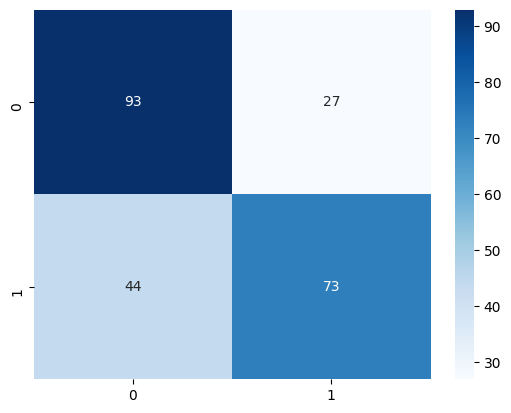

In [275]:
sns.heatmap(df_cm, annot=True, fmt='2g', cmap='Blues') # fmtで表示する数値の桁数を指定. 2gは小数点以下2桁まで表示
plt.yticks(va='top') # y軸の表示位置を中央に指定

ROC曲線，AUC計算<br>
ROC曲線：閾値（疾患の有無を判断する基準値）を変化させたときの偽陽性率と真陽性率（再現率）の各点を結んだもの．<br>
偽陽性率：FPR(FP/(FP+TN))<br>
真陽性率：TPR(TP/(TP+FN))<br>
AUC(Area Under the Curve): ROC曲線とx軸とy軸で囲まれた面積<br>
AUCは面積が大きいほど良いモデル

In [276]:
# 前のタスクでもみた通り，predict関数ではデフォルトが0.5に設定されている．
# 当然閾値を変化させればモデルの予測結果も変わる．
# 閾値を高い値に設定する，実際は疾患ありでも見逃してしまうケースが多くなる．
# 今回のタスクのような疾患ありの方を見逃すと大変なことになるので，多少疾患なしの方を疾患ありと予測してしまっても良いと考える．
# 閾値を低すぎる値に設定してしまうと実際に疾患リスクなしの人にまで過剰に反応してしまうため，役に立たないモデルになってしまう．

In [277]:
from sklearn.metrics import roc_auc_score, roc_curve # ROC曲線を描画する関数
auc_score = roc_auc_score(y_true = y_test, y_score = y_pred_proba_1) # AUCを計算，y_scoreには疾患ありの確率を入力
print(auc_score)

0.8186609686609686


Text(0, 0.5, 'true positive rate')

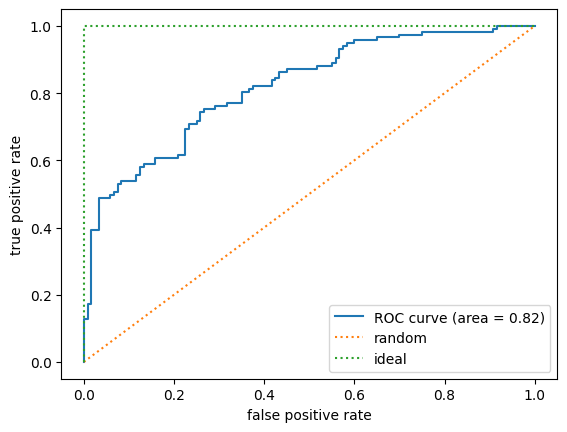

In [278]:
# ROC曲線を描画
fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred_proba_1) # fprは偽陽性率，tprは真陽性率，thresholdsは閾値
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc_score) # ROC曲線を描画
plt.plot([0, 1], [0, 1], linestyle=':', label='random') # 第一引数がx軸，第二引数がy軸
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal') 
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

予測精度改善のための方策例
1. データ量を変える
2. アルゴリズム変更・ハイパラチューニング
3. 特徴量を増やす・減らす
> 特徴量を作る：集約など<br>
特徴量を選ぶ：特徴量が多すぎると過学習になるリスクがある．

特徴量作成

ビニング（binning）：連続値をビンと呼ばれる離散値に置き換える処理（ある変数の値を複数の区分に分割することで新しい特徴量を作成）

In [279]:
# ビニングを行う
# T_Bilを等間隔に5等分したbinに変換
X_cut, bin_indice = pd.cut(X['T_Bil'], bins=5, retbins=True) # bins=5でデータの最小から最大までを５等分，retbins=Trueでbinの境界値を返す 
print('binの区切り: ', bin_indice)
print('bin区切りごとのデータ数: \n')
print(X_cut.value_counts())
# T_Bilを5等分するとほとんどのデータが同じビンに入ってしまう
# (0.425, 15.46]は0.425より大きく15.46以下のデータを意味する

binの区切り:  [ 0.4252 15.46   30.42   45.38   60.34   75.3   ]
bin区切りごとのデータ数: 

T_Bil
(0.425, 15.46]    756
(15.46, 30.42]     28
(30.42, 45.38]      5
(60.34, 75.3]       1
(45.38, 60.34]      0
Name: count, dtype: int64


In [280]:
# 左によっているため，ビニングの境界値を変更
bins_T_Bil = [0, 0.5, 1.0, 100] # ビンの境界値を指定
X_cut, bin_indice = pd.cut(X['T_Bil'], bins=bins_T_Bil, retbins=True) # bins=[]とリストを入れることで境界値を指定，retbins=Trueでbinの境界値を返す 
print('binの区切り: ', bin_indice)
print('bin区切りごとのデータ数: \n')
print(X_cut.value_counts())
# T_Bilを5等分するとほとんどのデータが同じビンに入ってしまう
# (0.425, 15.46]は0.425より大きく15.46以下のデータを意味する

binの区切り:  [  0.    0.5   1.  100. ]
bin区切りごとのデータ数: 

T_Bil
(1.0, 100.0]    441
(0.5, 1.0]      344
(0.0, 0.5]        5
Name: count, dtype: int64


In [281]:
# binのダミー変数化
bins_T_Bil = [0, 0.5, 1.0, 100] # ビンの境界値を指定
X_cut, bin_indice = pd.cut(X['T_Bil'], bins=bins_T_Bil, retbins=True, labels=False) # labels=Falseでビンの番号を返す
print('bin区切りごとのデータ数: \n')
print(X_cut.value_counts())
# labels=Falseでビンの番号を返す

bin区切りごとのデータ数: 

T_Bil
2    441
1    344
0      5
Name: count, dtype: int64


In [282]:
# bin分割した結果をダミー変数化
X_dummies = pd.get_dummies(X_cut, prefix=X_cut.name) # prefixで列名の接頭辞を指定, prefixがないと列名が0, 1, 2になる
X_dummies.head(5)

,T_Bil_0,T_Bil_1,T_Bil_2
0,False,True,False
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True


In [283]:
X_binned = pd.concat([X, X_dummies], axis=1) # bin分割した結果を結合
X_binned.head(5)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,T_Bil_0,T_Bil_1,T_Bil_2
0,65,0,1.0,0.2,187,16,18,6.8,3.3,0.92,False,True,False
1,62,1,11.2,5.6,699,64,100,7.5,3.2,0.73,False,False,True
2,62,1,7.6,4.2,490,60,68,7.0,3.3,0.87,False,False,True
3,58,1,1.3,0.5,182,14,20,6.8,3.4,0.98,False,False,True
4,72,1,4.2,2.1,195,27,59,7.3,2.4,0.48,False,False,True


In [284]:
# X_dummiesを使用してロジスティック回帰
# 精度はAUCで評価
X_train, X_test, y_train, y_test = train_test_split(X_binned, y, test_size=0.3, random_state=42) # test_sizeでテストデータの割合を指定，random_stateで乱数のシードを指定
lr = LogisticRegression() # モデルのインスタンス化
lr.fit(X_train, y_train) # 学習
y_pred_proba = lr.predict_proba(X_test) # 確率を出力
y_pred_proba_1 = y_pred_proba[:, 1] # 1列目の確率を出力
auc_score = roc_auc_score(y_true = y_test, y_score = y_pred_proba_1) # AUCを計算，y_scoreには疾患ありの確率を入力
print(auc_score)
# 精度が上がった

0.8631766381766381


Text(0, 0.5, 'true positive rate')

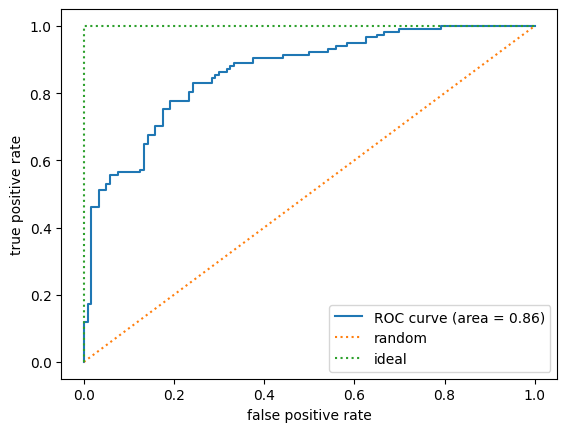

In [285]:
# ROC曲線を描画
fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred_proba_1) # fprは偽陽性率，tprは真陽性率，thresholdsは閾値
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc_score) # ROC曲線を描画
plt.plot([0, 1], [0, 1], linestyle=':', label='random') # 第一引数がx軸，第二引数がy軸
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal') 
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

多項式特徴量，交互作用特徴量作成

In [286]:
# 多項式特徴量，交互作用特徴量の例
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# サンプルデータ
a = np.array([[1, 2], [3, 4], [5, 6]])
print(a)
# 2次の多項式特徴量と交互作用特徴量を生成
poly = PolynomialFeatures(degree=2, include_bias=False) # degreeで次数を指定，include_bias=Trueにすると切片の1を含めたリストになる
a_poly = poly.fit_transform(a)

print(a_poly) # x1, x2, x1^2, x1x2, x2^2の順に並んでいる．多項式特徴量はx1**2, x2**2の列，交互作用特徴量はx1*x2である

[[1 2]
 [3 4]
 [5 6]]
[[ 1.  2.  1.  2.  4.]
 [ 3.  4.  9. 12. 16.]
 [ 5.  6. 25. 30. 36.]]


In [294]:
# 数値変数のみのデータを使用して多項式特徴量と交互作用特徴量を生成
print(df_numeric.shape)
df_numeric.head(5)

(790, 9)


,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,65,1.0,0.2,187,16,18,6.8,3.3,0.92
1,62,11.2,5.6,699,64,100,7.5,3.2,0.73
2,62,7.6,4.2,490,60,68,7.0,3.3,0.87
3,58,1.3,0.5,182,14,20,6.8,3.4,0.98
4,72,4.2,2.1,195,27,59,7.3,2.4,0.48


In [301]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False) # degreeで次数を指定，include_bias=Trueにすると切片の1を含めたリストになる
df_numeric_poly_arr = poly.fit_transform(df_numeric) # 多項式特徴量と交互作用特徴量を生成, nd.arrayで返ってくる
# データフレーム化
df_numeric_poly = pd.DataFrame(df_numeric_poly_arr, columns=['poly'+ str(x) for x in range(df_numeric_poly_arr.shape[1])]) # get_feature_namesで列名を取得
print(df_numeric_poly.shape) # 9次元から45次元に増えている
df_numeric_poly.head(5)
# 2次の多項式特徴量と交互作用特徴量を生成で54列の特徴量ができた．

(790, 54)


,poly0,poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,...,poly44,poly45,poly46,poly47,poly48,poly49,poly50,poly51,poly52,poly53
0,65.0,1.0,0.2,187.0,16.0,18.0,6.8,3.3,0.92,4225.0,...,324.0,122.4,59.4,16.56,46.24,22.44,6.256,10.89,3.036,0.8464
1,62.0,11.2,5.6,699.0,64.0,100.0,7.5,3.2,0.73,3844.0,...,10000.0,750.0,320.0,73.00,56.25,24.00,5.475,10.24,2.336,0.5329
2,62.0,7.6,4.2,490.0,60.0,68.0,7.0,3.3,0.87,3844.0,...,4624.0,476.0,224.4,59.16,49.00,23.10,6.090,10.89,2.871,0.7569
3,58.0,1.3,0.5,182.0,14.0,20.0,6.8,3.4,0.98,3364.0,...,400.0,136.0,68.0,19.60,46.24,23.12,6.664,11.56,3.332,0.9604
4,72.0,4.2,2.1,195.0,27.0,59.0,7.3,2.4,0.48,5184.0,...,3481.0,430.7,141.6,28.32,53.29,17.52,3.504,5.76,1.152,0.2304


In [302]:
# 生成した特徴量の中には目的変数との関連性が低く，ノイズとなっている特徴量もある．
# 特徴量を削る特徴量選択の方法を行う．
# 今回はモデルが自動で重要な特徴量を選択してくれる組み込み法を使用する．
# ロジスティック回帰のモデルを使用する．
from sklearn.feature_selection import SelectFromModel # 組み込み法のクラス
from sklearn.linear_model import LogisticRegression # ロジスティック回帰のモデル
# 組み込み法に使うモデルの指定
fs_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42) # penaltyで正則化の種類を指定，solverで最適化のアルゴリズムを指定
# solverは誤差を最小化するための関数の種類
# 注意点としては最適化関数の種類によっては使用できる正則化の種類が限られる
# penalty='l1'の時はsolver='liblinear'が使用可能
# penalty='l2'の時はsolver='lbfgs'のように
# fs_threshold = 'median' # 特徴量選択の閾値の指定, 中央値を基準に特徴量を選択
fs_threshold = 'mean'
# 組み込み法モデルの初期化
selector = SelectFromModel(fs_model, threshold=fs_threshold) # thresholdで閾値を指定

In [311]:
# 組み込み法モデルを使用し特徴量選択を行う
selector.fit(df_numeric_poly, y) # 学習
mask = selector.get_support() # yに関係のある特徴量のみTrue
df_numeric_poly_masked = df_numeric_poly.loc[:, mask] # 選択された特徴量のみのデータフレームを作成
print(df_numeric_poly_masked.shape) # 12次元にまで減った
df_numeric_poly_masked.head(5)
# 下のようにtransformerで一発でもできるが，df型にしないといけない
# X_selected = selector.transform(df_numeric_poly) # 特徴量選択を行う

(790, 12)


,poly1,poly2,poly6,poly7,poly8,poly23,poly24,poly25,poly26,poly32,poly50,poly52
0,1.0,0.2,6.8,3.3,0.92,6.80,3.30,0.920,0.04,0.184,6.256,3.036
1,11.2,5.6,7.5,3.2,0.73,84.00,35.84,8.176,31.36,4.088,5.475,2.336
2,7.6,4.2,7.0,3.3,0.87,53.20,25.08,6.612,17.64,3.654,6.090,2.871
3,1.3,0.5,6.8,3.4,0.98,8.84,4.42,1.274,0.25,0.490,6.664,3.332
4,4.2,2.1,7.3,2.4,0.48,30.66,10.08,2.016,4.41,1.008,3.504,1.152


In [313]:
# この選択肢た特徴量を使用してモデルをもう一度学習させる
X_train, X_test, y_train, y_test = train_test_split(df_numeric_poly_masked, y, test_size=0.3, random_state=42) # test_sizeでテストデータの割合を指定，random_stateで乱数のシードを指定
lr = LogisticRegression() # モデルのインスタンス化
lr.fit(X_train, y_train) # 学習
y_pred_proba = lr.predict_proba(X_test) # 確率を出力
y_pred_proba_1 = y_pred_proba[:, 1] # 1列目の確率を出力
auc_score = roc_auc_score(y_true = y_test, y_score = y_pred_proba_1) # AUCを計算，y_scoreには疾患ありの確率を入力
print(auc_score)
# 精度が上がった

0.8712250712250712


Text(0, 0.5, 'true positive rate')

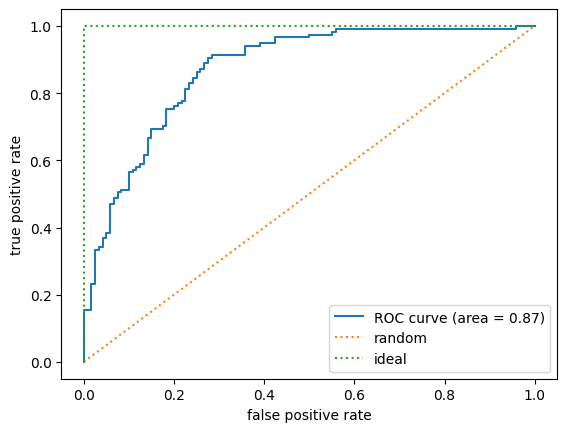

In [314]:
# ROC曲線を描画
fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred_proba_1) # fprは偽陽性率，tprは真陽性率，thresholdsは閾値
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc_score) # ROC曲線を描画
plt.plot([0, 1], [0, 1], linestyle=':', label='random') # 第一引数がx軸，第二引数がy軸
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal') 
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')